In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import pandas as pd

/tmp/ipykernel_2900448/2817862154.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [10]:
df = pd.read_csv('experiment_results/vanilla_fix_bug_compute_loss_encodev2.csv')
df

,dataset,algo,use_contrastive,seed,agent_id,avg_acc,final_acc,forward,backward,catastrophic
0,kmnist,modular,True,seed_4,agent_1,0.862619,0.85695,0.588643,0.022345,1.205
1,kmnist,modular,True,seed_4,agent_2,0.873906,0.86520,0.630786,0.026440,0.675
2,kmnist,modular,True,seed_4,agent_6,0.858994,0.85400,0.507786,0.024274,0.350
3,kmnist,modular,True,seed_4,agent_7,0.854229,0.83240,0.554571,0.023643,1.035
4,kmnist,modular,True,seed_4,agent_4,0.877834,0.86745,0.593643,0.027179,-0.230
...,...,...,...,...,...,...,...,...,...,...
763,kmnist,monolithic,False,seed_0,agent_7,0.794951,0.79635,0.816500,0.018167,1.905
764,kmnist,monolithic,False,seed_0,agent_4,0.799761,0.77635,0.787929,0.017571,3.500
765,kmnist,monolithic,False,seed_0,agent_3,0.798413,0.76665,0.841286,0.008333,5.430
766,kmnist,monolithic,False,seed_0,agent_0,0.835836,0.84905,0.856071,0.023798,0.200


In [22]:

def aggregate_results(df):
   m = df.groupby(["algo", "dataset", "use_contrastive"])[
         "final_acc"].mean()
   stderr = df.groupby(["algo", "dataset", "use_contrastive"])["final_acc"].sem()
   return m, stderr

def plot_vanilla_res(df):
   # modular_means when algo == "modular" and use_contrastive == False
   datasets = df['dataset'].unique()
   m, stderr = aggregate_results(df)

   modular_means = [m[('modular', dataset, False)] for dataset in datasets]
   modular_stderr = [stderr[('modular', dataset, False)] for dataset in datasets]

   modular_contrastive_means = [m[('modular', dataset, True)] for dataset in datasets]
   modular_contrastive_stderr = [stderr[('modular', dataset, True)] for dataset in datasets]

   monolithic_means = [m[('monolithic', dataset, False)] for dataset in datasets]
   monolithic_stderr = [stderr[('monolithic', dataset, False)] for dataset in datasets]

   monolithic_contrastive_means = [m[('monolithic', dataset, True)] for dataset in datasets]
   monolithic_contrastive_stderr = [stderr[('monolithic', dataset, True)] for dataset in datasets]

   # Set colors
   modular_color = '#3182bd'
   modular_contrastive_color = '#9ecae1'
   monolithic_color = '#de2d26'
   monolithic_contrastive_color = '#fc9272'


   # Set figure size
   fig, ax = plt.subplots(figsize=(10,4))

   # Plot data
   bar_width = 0.2
   opacity = 0.8


   linewidth = 2

   rects1 = ax.bar(np.arange(len(modular_means))-bar_width, modular_means, bar_width,
                  yerr=modular_stderr, alpha=opacity, color=modular_color, label='Modular',
                  edgecolor='#214073',
                  linewidth=linewidth,
               )
   rects2 = ax.bar(np.arange(len(modular_contrastive_means)), modular_contrastive_means, bar_width,
                  yerr=modular_contrastive_stderr, alpha=opacity, color=modular_contrastive_color, label='Modular + Contrastive',
                  edgecolor='#6a9bbd',
                  linewidth=linewidth,
                  )
   rects3 = ax.bar(np.arange(len(monolithic_means))+bar_width, monolithic_means, bar_width,
                  yerr=monolithic_stderr, alpha=opacity, color=monolithic_color, label='Monolithic',
                  edgecolor='#a6221f',
                                 linewidth=linewidth,)
   rects4 = ax.bar(np.arange(len(monolithic_contrastive_means))+bar_width*2, monolithic_contrastive_means, bar_width,
                  yerr=monolithic_contrastive_stderr, alpha=opacity, color=monolithic_contrastive_color, label='Monolithic + Contrastive',
                  edgecolor='#d4756d',
                  linewidth=linewidth,
                  )


   # datasets = ['CIFAR-100']
   # datasets = ['MNIST', 'FashionMNIST', 'KMNIST', 'CIFAR-100', 'Gridworld', 'Composuite']
   x = np.arange(len(datasets))
   ax.set_xticks(x)
   ax.set_xticklabels(datasets)
   ax.set_ylim([0.5, 1])
   ax.set_ylabel('Accuracy', fontsize=14)
   ax.set_xlabel('Dataset', fontsize=14)
   # leg = ax.legend(frameon=True)
   # leg.get_frame().set_edgecolor('b')

   ax.set_title('Comparison of Algorithm Performance', fontsize=16, fontweight='bold')


   # ax.legend(frameon=True, loc='lower center')
   ax.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.28, 0.0));
   ax.grid(True, which='major', linestyle='--', alpha=0.5);
   plt.savefig(f"Figures/vanilla/results.pdf", bbox_inches="tight")

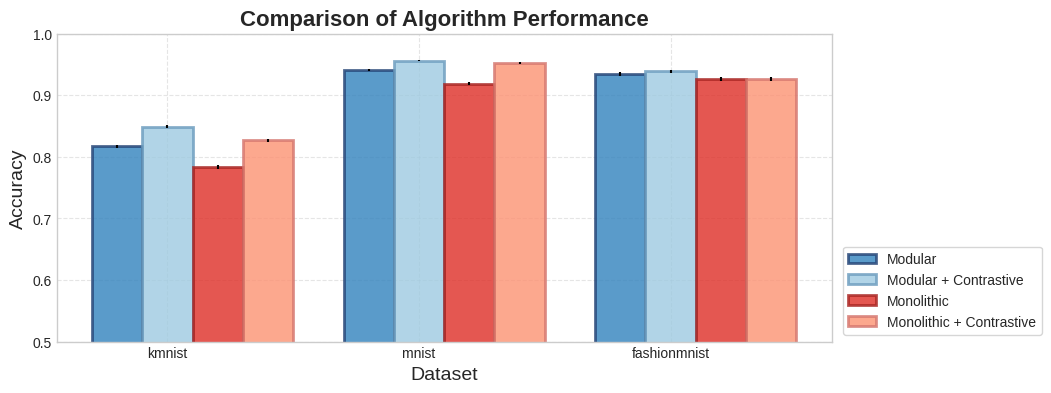

In [19]:
plot_vanilla_res(df)

In [21]:
df2 = pd.read_csv('experiment_results/modmod_test_sync_base_True_opt_with_random_False.csv')
df2

,dataset,algo,use_contrastive,seed,agent_id,avg_acc,final_acc,forward,backward,catastrophic
0,kmnist,modular,True,seed_4,agent_1,0.849698,0.856450,0.659214,0.024417,0.210000
1,kmnist,modular,True,seed_4,agent_2,0.850532,0.838750,0.662571,0.023452,0.615000
2,kmnist,modular,True,seed_4,agent_6,0.831000,0.824300,0.579000,0.019464,2.290000
3,kmnist,modular,True,seed_4,agent_7,0.840054,0.841250,0.601286,0.026702,-0.750000
4,kmnist,modular,True,seed_4,agent_4,0.835664,0.829000,0.595857,0.022393,1.060000
...,...,...,...,...,...,...,...,...,...,...
187,fashionmnist,modular,True,seed_0,agent_7,0.979107,0.975429,0.623125,0.078361,0.371429
188,fashionmnist,modular,True,seed_0,agent_4,0.975794,0.966143,0.604000,0.080472,-0.171429
189,fashionmnist,modular,True,seed_0,agent_3,0.973930,0.956786,0.684125,0.079806,0.000000
190,fashionmnist,modular,True,seed_0,agent_0,0.957687,0.904214,0.578125,0.080083,-0.071429


In [23]:
m, stderr = aggregate_results(df)
m2, stderr2 = aggregate_results(df2)

In [24]:
m2

algo     dataset       use_contrastive
modular  fashionmnist  True               0.938436
         kmnist        True               0.846483
         mnist         True               0.952658
Name: final_acc, dtype: float64

In [26]:
m

algo        dataset       use_contrastive
modular     fashionmnist  False              0.934341
                          True               0.938617
            kmnist        False              0.816793
                          True               0.848949
            mnist         False              0.941312
                          True               0.956216
monolithic  fashionmnist  False              0.925544
                          True               0.926089
            kmnist        False              0.783684
                          True               0.826601
            mnist         False              0.918772
                          True               0.952409
Name: final_acc, dtype: float64

In [51]:
def legend_without_duplicate_labels(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), **kwargs)

In [55]:
def plot_dfs_comp(m, stderr, m2, stderr2):
   # Get datasets from m2
   datasets = m2.index.get_level_values('dataset').unique()

   # Set colors
   modular_color = '#3182bd'
   modular_contrastive_color = '#9ecae1'
   monolithic_color = '#de2d26'
   monolithic_contrastive_color = '#fc9272'

   # Set figure size
   fig, ax = plt.subplots(figsize=(10,4))

   # Plot data for m
   bar_width = 0.2
   opacity = 0.8
   linewidth = 2

   for i, dataset in enumerate(datasets):
       for algo in m2.index.levels[0]:
           for use_contrastive in m2.index.levels[-1]:
               if (algo, dataset, use_contrastive) in m.index:
                   means = m[(algo, dataset, use_contrastive)]
                   std_err = stderr[(algo, dataset, use_contrastive)]
                   label = f'{algo.title()} + {"Contrastive" if use_contrastive else "Vanilla"}'
                   color = modular_contrastive_color if use_contrastive else modular_color
                   rects = ax.bar(i - bar_width / 2, means, bar_width,
                                  yerr=std_err, alpha=opacity, color=color,
                                  label=f'{label} (vanilla)', edgecolor='#214073', linewidth=linewidth)

   # Plot data for m2 with lighter shades
   for i, dataset in enumerate(datasets):
       for algo in m2.index.levels[0]:
           for use_contrastive in m2.index.levels[-1]:
               if (algo, dataset, use_contrastive) in m2.index:
                   means = m2[(algo, dataset, use_contrastive)]
                   std_err = stderr2[(algo, dataset, use_contrastive)]
                   label = f'{algo.title()} + {"Contrastive" if use_contrastive else "Vanilla"}'
                   color = 'lightblue' if use_contrastive else 'lightgreen'
                   rects = ax.bar(i + bar_width / 2, means, bar_width,
                                  yerr=std_err, alpha=0.6, color=color,
                                  label=f'{label} (modmod)', edgecolor='#6a9bbd', linewidth=linewidth, hatch='/')

   # Set x-axis ticks and labels
   ax.set_xticks(np.arange(len(datasets)))
   ax.set_xticklabels(datasets)

   # Set y-axis label and plot title
   ax.set_ylim([0.5, 1])
   ax.set_ylabel('Accuracy', fontsize=14)
   ax.set_xlabel('Dataset', fontsize=14)
   ax.set_title('Comparison of Algorithm Performance', fontsize=16, fontweight='bold')

   # Add legend and grid
   legend_without_duplicate_labels(ax, frameon=True, loc='lower right', bbox_to_anchor=(1.28, 0.0))

   ax.grid(True, which='major', linestyle='--', alpha=0.5)

   # Show plot
   plt.show()


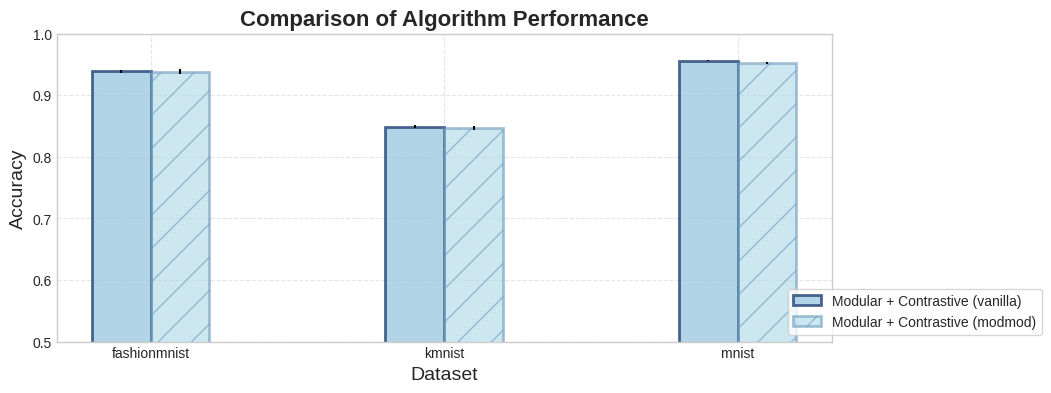

In [56]:
plot_dfs_comp(m, stderr, m2, stderr2)

In [36]:
m2

algo     dataset       use_contrastive
modular  fashionmnist  True               0.938436
         kmnist        True               0.846483
         mnist         True               0.952658
Name: final_acc, dtype: float64

In [37]:
m

algo        dataset       use_contrastive
modular     fashionmnist  False              0.934341
                          True               0.938617
            kmnist        False              0.816793
                          True               0.848949
            mnist         False              0.941312
                          True               0.956216
monolithic  fashionmnist  False              0.925544
                          True               0.926089
            kmnist        False              0.783684
                          True               0.826601
            mnist         False              0.918772
                          True               0.952409
Name: final_acc, dtype: float64